# Adversarial Training
A first approach to make the CNN model more robust to gradient-based adversarial attacks. <br>
It consists of finetuning the pretrained model with both clean and adversarial examples. <br>

In [1]:
import os
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import utils
import random
import torchvision.models as models

# reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


### Preprocessing

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_folder = "mri_brain_tumor"

train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

In [3]:
#mean, std = utils.compute_mean_std(train_loader)
mean, std = torch.tensor([0.1855]*3), torch.tensor([0.1813]*3) # precomputed, to save time

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


In [4]:
# Transformation for training dataset with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Randomly flip the image horizontally
    transforms.RandomRotation(10),         # Randomly rotate the image by 10 degrees
    transforms.Resize((224, 224)),         # Resize the image to 224x224
    transforms.ToTensor(),                 # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image
])

# Transformation for testing dataset without data augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize the image to 224x224
    transforms.ToTensor(),                 # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image
])

# Apply the transformations to the datasets
train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=train_transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

### Loading pretrained custom model (CNN)

In [5]:
model = utils.CNN(num_classes=4).to(device)
#load weights
model.load_state_dict(torch.load('weights/cnn.pth'))
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#print model summary with torchsummary
from torchsummary import summary
summary(model, (3, 224, 224))


C:\Users\gnele\AppData\Local\Temp\ipykernel_1720\1712107068.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/cnn.pth'))


Total number of parameters: 51476484
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 512]      51,380,736
           Linear-11                    [-1, 4]           2,052
Total params: 51,476,484
Trainable params: 51,476,484
Non-trainable params: 0
----------------------------------------------------

# Adversarial train function
Use both original and noisy images to train the model. <br>
We also apply image augmentation techniques to make the model more robust to adversarial attacks. <br>


In [6]:

def adversarial_train(dataloader, model, device, num_epochs, optimizer, criterion, attack_function, attack_params, epsilons):
    """
    This function trains the model using adversarial training. It generates adversarial images using the attack function and then appends them to the original images.
    Args:
    - dataloader: the dataloader for the dataset
    - model: the model to train
    - device: the device to train on
    - num_epochs: the number of epochs to train
    - attack function: generates the adversarial images (can be fgsm or pgd). If None, no adversarial training is performed
    - attack_params: method-specific parameters for the attack function (dictionary)
    - epsilons: the list of epsilon values to use for the attack. Each step will use one of these values at random
    """

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):

            images, labels = images.to(device), labels.to(device)
            if attack_function is not None:
                #chose an epsilon value at random, and update the attack_params dictionary accordingly
                if epsilons is not None:
                    attack_params['epsilon'] = random.choice(epsilons)
                attack_images = attack_function(model, criterion, images, labels, device, **attack_params) #the first arguments are the same, the rest are the method-specific attack_params
                #append the attack images to the images (the batch size will double!)
                images = torch.cat((images, attack_images), 0)
                labels = torch.cat((labels, labels), 0)

            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Loss: {running_loss/len(dataloader):.4f}")
        running_loss = 0.0

    print("Training complete.")

# **FGSM** - Fast Gradient Sign Method
Let's train the model with FGSM adversarial examples. <br>

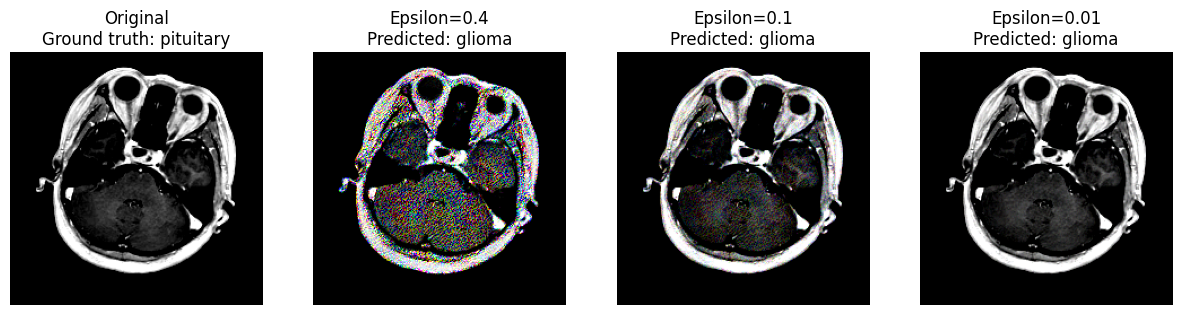

In [23]:
#get one batch of test images
images, labels = next(iter(test_loader))
utils.plot_images(model, images, labels, [0,0.4, 0.1, 0.01], utils.fgsm_attack)

In [7]:
#define a new model
robust_model = utils.CNN(num_classes=4).to(device)
robust_model.load_state_dict(torch.load('weights/cnn.pth'))
optimizer = optim.Adam(robust_model.parameters(), lr=0.0001)
criterion=nn.CrossEntropyLoss()
attack_function = utils.fgsm_attack
attack_params = {"epsilon": 0.1}
adversarial_train(train_loader, robust_model, device, 5, optimizer, criterion,
                  attack_function, attack_params, epsilons=[0.1, 0.05, 0.01])

C:\Users\gnele\AppData\Local\Temp\ipykernel_1720\1059884100.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  robust_model.load_state_dict(torch.load('weights/cnn.pth'))


' adversarial_train(train_loader, robust_model, device, 5, optimizer, criterion,\n                  attack_function, attack_params, epsilons=[0.1, 0.05, 0.01]) '

In [8]:
#torch.save(robust_model.state_dict(),'weights/robust_fgsm.pth')
robust_model.load_state_dict(torch.load('weights/robust_fgsm.pth'))

C:\Users\gnele\AppData\Local\Temp\ipykernel_1720\4243599714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  robust_model.load_state_dict(torch.load('weights/robust_fgsm.

<All keys matched successfully>

### Evaluate FGSM

In [10]:
epsilon_values=[ 0.1, 0.01, 0.005, 0.002, 0.001]
for eps in epsilon_values:
    print("\n\n--------- EPSILON VALUE: ", eps, " ---------")
    utils.compare_eval(robust_model,test_loader, criterion, device, attack_function=utils.fgsm_attack, attack_params={"epsilon": eps})



--------- EPSILON VALUE:  0.1  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:12<00:00,  2.52it/s]


Original accuracy: 	0.95
Adversarial accuaracy: 	0.82


--------- EPSILON VALUE:  0.01  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:11<00:00,  2.66it/s]


Original accuracy: 	0.96
Adversarial accuaracy: 	0.84


--------- EPSILON VALUE:  0.005  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:11<00:00,  2.67it/s]


Original accuracy: 	0.95
Adversarial accuaracy: 	0.86


--------- EPSILON VALUE:  0.002  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:11<00:00,  2.68it/s]


Original accuracy: 	0.95
Adversarial accuaracy: 	0.87


--------- EPSILON VALUE:  0.001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:11<00:00,  2.64it/s]

Original accuracy: 	0.96
Adversarial accuaracy: 	0.87


# **PGD** - Projected Gradient Descent
A more advanced attack than FGSM, that still uses the gradient of the loss function to generate adversarial examples, but it applies multiple steps of small perturbations to the input image. <br>
Since it works similarly to FGSM, we can use the same adversarial training approach to make the model more robust to PGD attacks, this time using the PGD adversarial examples. <br>


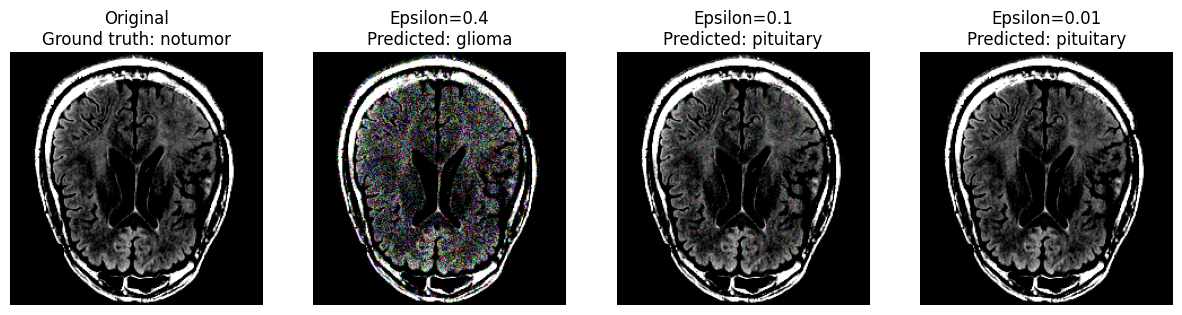

In [27]:

utils.plot_images(model, images, labels, [0,0.4, 0.1, 0.01], utils.pgd_attack)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0231661..3.9085367].


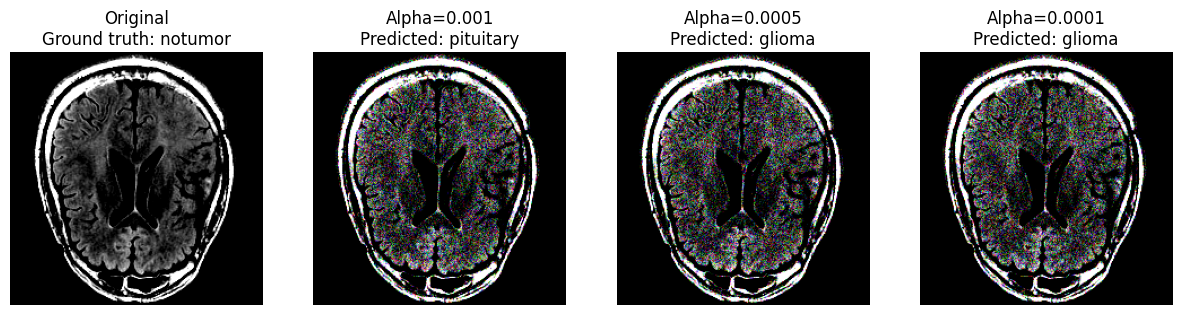

In [34]:
utils.plot_images(model, images, labels, [0,0.001, 0.0005, 0.0001], utils.pgd_attack)

In [9]:
#define a new model
robust_model_pdg = utils.CNN(num_classes=4).to(device)
robust_model_pdg.load_state_dict(torch.load('weights/cnn.pth'))
optimizer = optim.Adam(robust_model_pdg.parameters(), lr=0.0001)
criterion=nn.CrossEntropyLoss()
pgd = utils.pgd_attack
pgd_params = {"epsilon":0.01, "alpha":0.001, "num_iter":5}
adversarial_train(train_loader, robust_model_pdg, device, 5, optimizer, criterion,
                  pgd, pgd_params, epsilons=[0.1, 0.05, 0.01])

C:\Users\gnele\AppData\Local\Temp\ipykernel_1720\3198961008.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  robust_model_pdg.load_state_dict(torch.load('weights/cnn.pth'

Loss: 0.3465


Epoch [2/5]: 100%|██████████| 714/714 [05:42<00:00,  2.08it/s]


Loss: 0.2435


Epoch [3/5]: 100%|██████████| 714/714 [13:58<00:00,  1.17s/it]


Loss: 0.1978


Epoch [4/5]: 100%|██████████| 714/714 [15:08<00:00,  1.27s/it]


Loss: 0.1709


Epoch [5/5]: 100%|██████████| 714/714 [14:14<00:00,  1.20s/it]

Loss: 0.1454
Training complete.


In [10]:
#save/load weights
torch.save(robust_model_pdg.state_dict(),'weights/robust_pgd.pth')
#robust_model_pdg.load_state_dict(torch.load('weights/robust_pgd.pth'))

### Evaluate PGD
Keeping epsilon constant to 0.01, changing alpha.

In [12]:
alphas=[0.001, 0.0005, 0.0001]
for alpha in alphas:
    print("\n\n--------- ALPHA VALUE: ", alpha, " ---------")
    utils.compare_eval(robust_model_pdg,test_loader, criterion, device, attack_function=utils.pgd_attack, attack_params={"epsilon":0.01, "alpha":alpha, "num_iter":5})




--------- ALPHA VALUE:  0.001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:35<00:01,  1.14s/it]


Original accuracy: 	0.97
Adversarial accuaracy: 	0.83


--------- ALPHA VALUE:  0.0005  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:35<00:01,  1.13s/it]


Original accuracy: 	0.97
Adversarial accuaracy: 	0.90


--------- ALPHA VALUE:  0.0001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:34<00:01,  1.12s/it]

Original accuracy: 	0.98
Adversarial accuaracy: 	0.92


## Cross evaluations
Let's evaluate the model trained with FGSM adversarial examples using PGD adversarial examples, and vice-versa. <br>
This way we can see how the techniques generalize to different types of adversarial attacks. <br>
Each version has its pros and cons:
- FGSM is faster to compute, but less effective than PGD.
- PGD is more effective, but slower to compute.

### Evaluate FGSM using the PGD-trained model

In [13]:
fgsm=utils.fgsm_attack
epsilon_values=[0.1, 0.01, 0.005, 0.002, 0.001]
for eps in epsilon_values:
    print("\n\n--------- EPSILON VALUE: ", eps, " ---------")
    utils.compare_eval(robust_model_pdg,test_loader, criterion, device, fgsm, attack_params={"epsilon": eps})



--------- EPSILON VALUE:  0.1  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:12<00:00,  2.52it/s]


Original accuracy: 	0.97
Adversarial accuaracy: 	0.46


--------- EPSILON VALUE:  0.01  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:12<00:00,  2.55it/s]


Original accuracy: 	0.98
Adversarial accuaracy: 	0.84


--------- EPSILON VALUE:  0.005  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:12<00:00,  2.56it/s]


Original accuracy: 	1.00
Adversarial accuaracy: 	0.86


--------- EPSILON VALUE:  0.002  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:12<00:00,  2.56it/s]


Original accuracy: 	0.98
Adversarial accuaracy: 	0.87


--------- EPSILON VALUE:  0.001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:12<00:00,  2.54it/s]

Original accuracy: 	0.98
Adversarial accuaracy: 	0.91


### Evaluate PGD using the FGSM-trained model

In [11]:
alphas=[0.001, 0.0005, 0.0001]
for alpha in alphas:
    print("\n\n--------- ALPHA VALUE: ", alpha, " ---------")
    utils.compare_eval(robust_model,test_loader, criterion, device, attack_function=utils.pgd_attack, attack_params={"eps":0.01, "alpha":alpha, "num_iter":5})




--------- ALPHA VALUE:  0.001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:35<00:01,  1.16s/it]


Original accuracy: 	0.96
Adversarial accuaracy: 	0.89


--------- ALPHA VALUE:  0.0005  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:35<00:01,  1.15s/it]


Original accuracy: 	0.96
Adversarial accuaracy: 	0.87


--------- ALPHA VALUE:  0.0001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:35<00:01,  1.15s/it]

Original accuracy: 	0.95
Adversarial accuaracy: 	0.88


# **Resnet18** - fine tuning
Let's try the same approach with a more complex model, pretrained on ImageNet. <br>
We freeze the convolutional layers and train only the last fully connected layers. <br>
As before, we use both clean and adversarial examples to train the model (both FGSM and PGD). <br>


In [14]:
# Get the pretrained ResNet18 model on ImageNet from torchvision.models
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet.fc = nn.Linear(resnet.fc.in_features, 4) 
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

# print number of total params
print(f"Total number of parameters: {sum(p.numel() for p in resnet.parameters())}")
# print number of trainable params
print(f"Number of trainable parameters: {sum(p.numel() for p in resnet.parameters() if p.requires_grad)}")

Total number of parameters: 11178564
Number of trainable parameters: 11178564


Adversarial training requires the model to be initialized first, so we do two epochs with clean examples only. <br>
We also do a quick evaluation to see how the model performs before adversarial training. <br>

In [16]:
adversarial_train(train_loader, resnet, device, 5, optimizer, criterion,
                  attack_function=None, attack_params=None, epsilons=None)

Epoch [1/5]: 100%|██████████| 714/714 [02:51<00:00,  4.16it/s]


Loss: 0.2950


Epoch [2/5]: 100%|██████████| 714/714 [02:49<00:00,  4.21it/s]


Loss: 0.1223


Epoch [3/5]: 100%|██████████| 714/714 [02:48<00:00,  4.23it/s]


Loss: 0.0868


Epoch [4/5]: 100%|██████████| 714/714 [02:49<00:00,  4.21it/s]


Loss: 0.0700


Epoch [5/5]: 100%|██████████| 714/714 [02:49<00:00,  4.21it/s]

Loss: 0.0421
Training complete.


In [17]:
torch.save(resnet.state_dict(),'weights/resnet_clean.pth')

In [22]:
utils.compare_eval(resnet, test_loader, criterion, device, attack_function=utils.fgsm_attack, attack_params={"epsilon": 0.1})

Testing Progress:  97%|█████████▋| 31/32 [00:16<00:00,  1.93it/s]

Original accuracy: 	0.99
Adversarial accuaracy: 	0.42


Then we actually apply adversarial training, using both clean and adversarial examples. <br>

In [24]:
pgd_params = {"epsilon":0.01, "alpha":0.001, "num_iter":5}
adversarial_train(train_loader, resnet, device, 5, optimizer, criterion,
                  utils.pgd_attack, pgd_params, epsilons=[0.1, 0.05, 0.01])

Epoch [1/5]: 100%|██████████| 714/714 [13:29<00:00,  1.13s/it]


Loss: 0.1517


Epoch [2/5]: 100%|██████████| 714/714 [07:07<00:00,  1.67it/s]


Loss: 0.0753


Epoch [3/5]: 100%|██████████| 714/714 [08:11<00:00,  1.45it/s]


Loss: 0.0634


Epoch [4/5]: 100%|██████████| 714/714 [10:25<00:00,  1.14it/s]


Loss: 0.0471


Epoch [5/5]: 100%|██████████| 714/714 [13:35<00:00,  1.14s/it]

Loss: 0.0386
Training complete.


In [25]:
torch.save(resnet.state_dict(),'weights/robust_resnet.pth')

## Evaluate Resnet 
For both FGSM and PGD adversarial examples.
### PGD

In [28]:
print("PGD attack")
alphas=[0.001, 0.0005, 0.0001]
for alpha in alphas:
    print("\n\n--------- ALPHA VALUE: ", alpha, " ---------")
    utils.compare_eval(resnet, test_loader, criterion, device, attack_function=utils.pgd_attack, attack_params={"epsilon":0.05, "alpha":alpha, "num_iter":5})

PGD attack


--------- ALPHA VALUE:  0.001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:42<00:01,  1.38s/it]


Original accuracy: 	1.00
Adversarial accuaracy: 	0.96


--------- ALPHA VALUE:  0.0005  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:26<00:00,  1.19it/s]


Original accuracy: 	1.00
Adversarial accuaracy: 	0.96


--------- ALPHA VALUE:  0.0001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:43<00:01,  1.39s/it]

Original accuracy: 	1.00
Adversarial accuaracy: 	0.96


### FGSM

In [29]:
fgsm=utils.fgsm_attack
epsilon_values=[0.1, 0.01, 0.005, 0.002, 0.001]
for eps in epsilon_values:
    print("\n\n--------- EPSILON VALUE: ", eps, " ---------")
    utils.compare_eval(resnet, test_loader, criterion, device, fgsm, attack_params={"epsilon": eps})



--------- EPSILON VALUE:  0.1  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:14<00:00,  2.11it/s]


Original accuracy: 	1.00
Adversarial accuaracy: 	0.67


--------- EPSILON VALUE:  0.01  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:14<00:00,  2.09it/s]


Original accuracy: 	1.00
Adversarial accuaracy: 	0.93


--------- EPSILON VALUE:  0.005  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:16<00:00,  1.93it/s]


Original accuracy: 	1.00
Adversarial accuaracy: 	0.98


--------- EPSILON VALUE:  0.002  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:15<00:00,  2.04it/s]


Original accuracy: 	1.00
Adversarial accuaracy: 	0.96


--------- EPSILON VALUE:  0.001  ---------


Testing Progress:  97%|█████████▋| 31/32 [00:15<00:00,  2.06it/s]

Original accuracy: 	1.00
Adversarial accuaracy: 	0.96
